# Pytorch 影像辨識網路模型介紹 (進階)

核心精神: 越深越好!!! 參數量&運算量越少越好!!!


1. ResNet (ILSVRC2015) - ResBlock
2. GoogleLeNet - InceptionBlock
3.  DenseNet (2016) - DenseBlock
4.  MobileNet(2017) - Depthwise


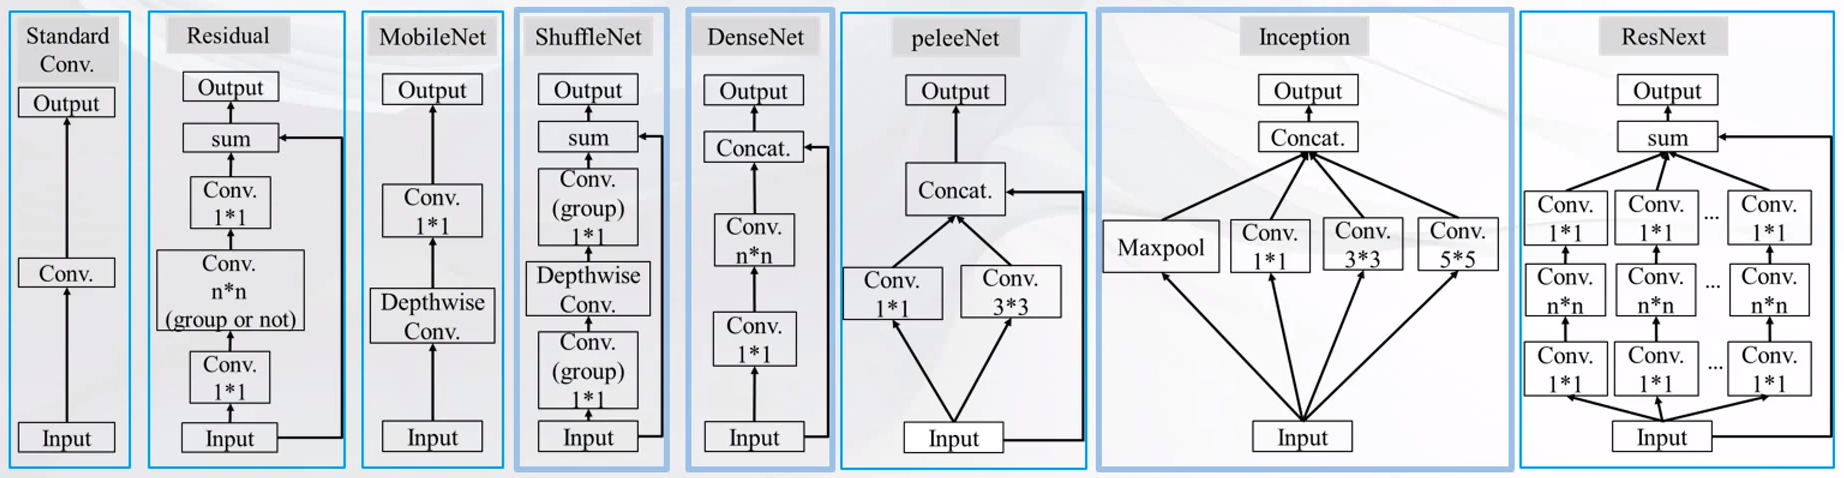




## 影像辨識資料庫


分類:
1. MNIST (28 * 28)
   10 類別: train 6000, test 1000

2. CIFAR10/CIFAR100 (32 * 32)
    每類10000張圖
   
3. ImageNet (大小不限定)
    22000類別，每類500-1000張

物件偵測:
1. Pascal VOC
2. MS-COCO

Segmentation:
1. Pascal VOC
2. Cityscape
3. the KITTI database



## ResNet (ILSVRC2015) - ResBlock

微軟的ResNet模型有152層。透過實驗發現，隨著層數的增加，模型的錯誤率會逐漸降低，這跟一般的網絡模型在增加一些層之後，訓練和測試的錯誤率反而會升高。
一個比較直觀的理解是，殘差塊（ResNet中的一個關鍵概念）主要功能是直接連接前一層與後一層，目的是降低梯度消失或爆炸。



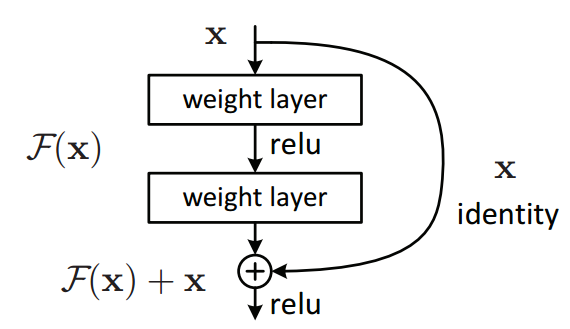
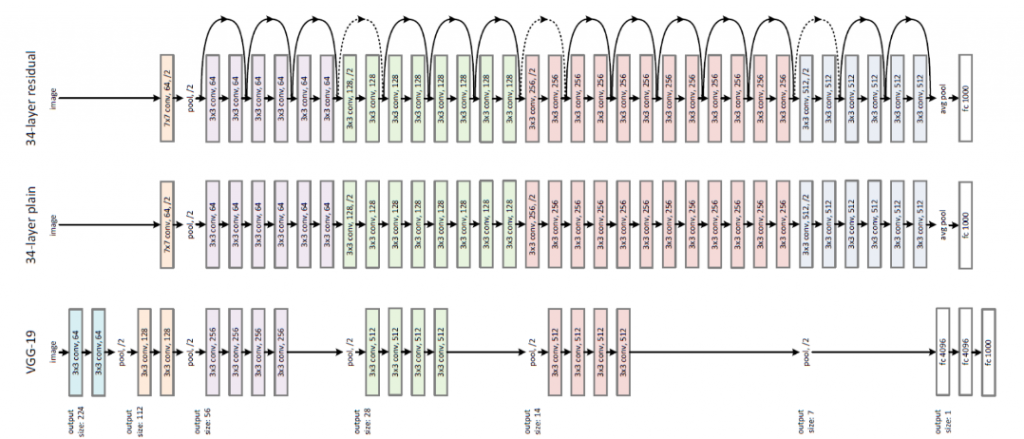 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class ResBlock(nn.Module):
    def __init__( self, inplanes: int, planes: int,  stride: int = 1) -> None:
        super(ResBlock, self).__init__()
        norm_layer = nn.BatchNorm2d
        
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,padding=1)
        self.bn2 = norm_layer(planes)
        
        self.conv3 = nn.Conv2d(planes, inplanes, kernel_size=1, stride=stride)
        self.bn3 = norm_layer(inplanes)       
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        out += identity
        out = self.relu(out)
        return out
    
    
ResConv = ResBlock(inplanes=3,planes=10)
print(ResConv)


# Export the model to ONNX
dummy_input = torch.rand(1,3,512,512)
torch.onnx.export(
    model=ResConv,                        # Your model instance
    args=dummy_input,                     # Model's input tensor (or a tuple for multiple inputs)
    f='./onnx/ResConv.onnx',              # Path to save the ONNX model
    opset_version=11,                     # ONNX opset version to use
    input_names=['input'],                # Optionally define the input tensor name
    output_names=['output'],              # Optionally define the output tensor name
)

ResBlock(
  (conv1): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 3, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


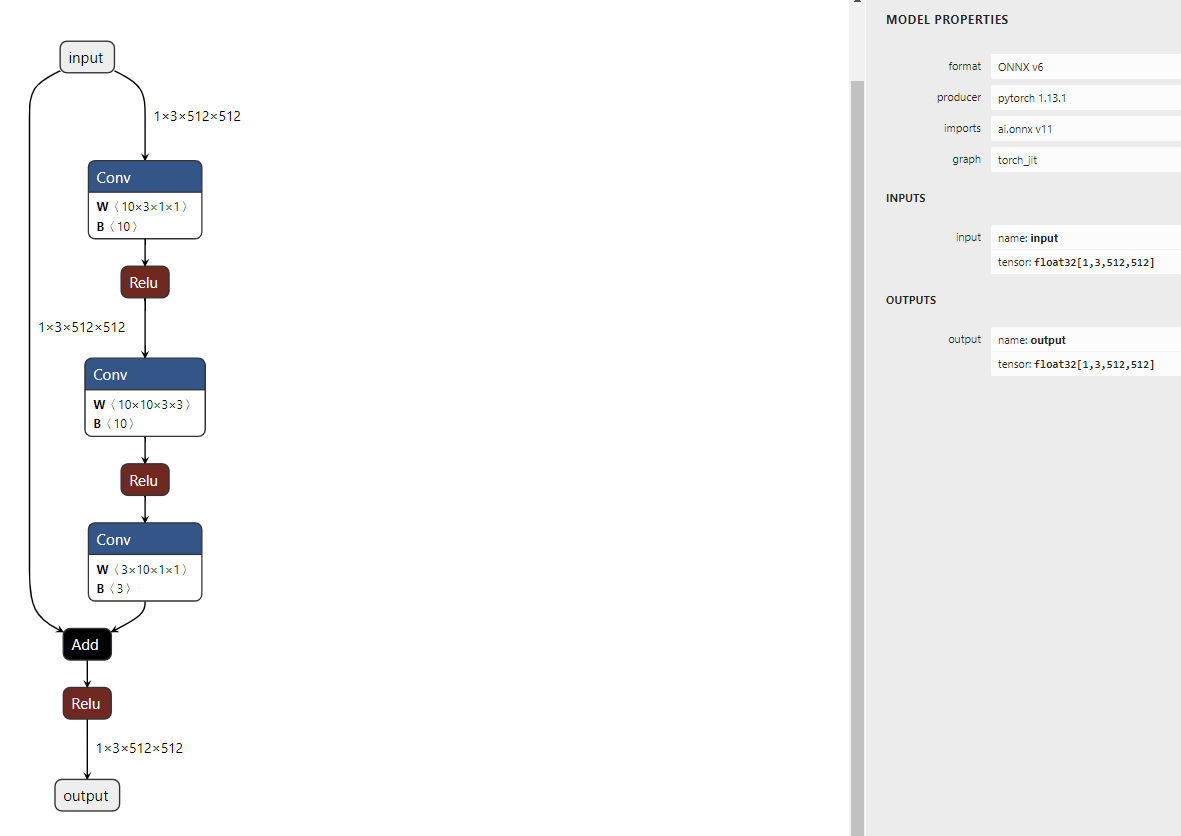

## MobileNet(2017) - Depthwise

輕量化模型
Depthwise = Group conv ( group = inchannel = outchannel)

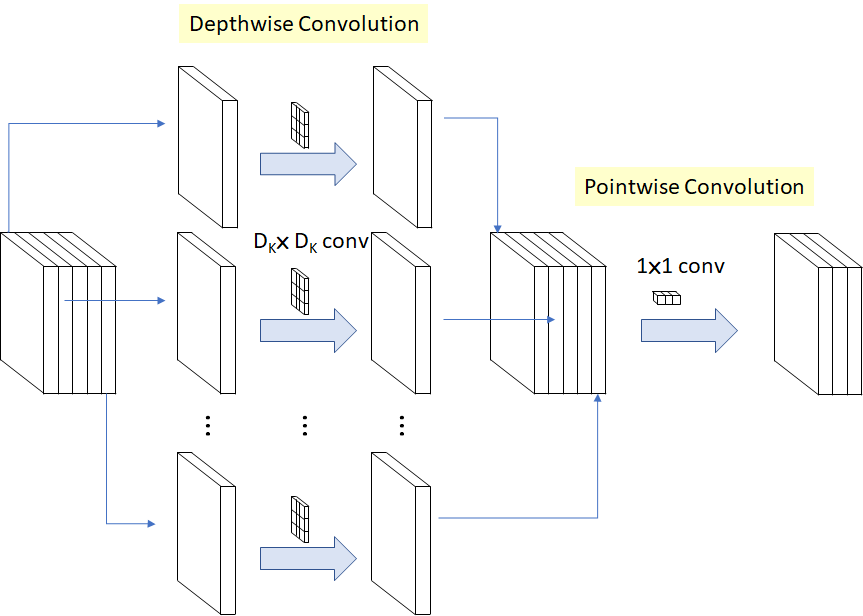

In [7]:
# Depthwise Separable Convolution - 方法一
class DepthwiseSeparable_Conv(nn.Module):
    def __init__( self, inplanes: int, outplanes: int, stride: int = 1) -> None:
        super(DepthwiseSeparable_Conv, self).__init__()
        norm_layer = nn.BatchNorm2d
        
        self.conv1 = nn.Conv2d(inplanes, inplanes, 3, stride, 1, groups=inplanes, bias=False)
        self.bn1 = norm_layer(inplanes)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = norm_layer(outplanes)
     
    def  forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out
    
# Depthwise Separable Convolution - 方法二
class DepthwiseSeparable_Conv(nn.Module):
    def __init__( self, inplanes: int, outplanes: int, stride: int = 1) -> None:
        super(DepthwiseSeparable_Conv, self).__init__()
        norm_layer = nn.BatchNorm2d
        
        self.conv_dws =  nn.Sequential(
            nn.Conv2d(inplanes, inplanes, 3, stride, 1, groups=inplanes, bias=False),
            norm_layer(inplanes),
            nn.ReLU(inplace=True),

            nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0, bias=False),
            norm_layer(outplanes),
            nn.ReLU(inplace=True),
        )
     
    def  forward(self, x):
        out = self.conv_dws(x)
        return out
    
DSconv = DepthwiseSeparable_Conv(inplanes=3,outplanes=10)
print(DSconv)

# Export the model to ONNX
dummy_input = torch.rand(1,3,10,10)
torch.onnx.export(
    model=DSconv,                        # Your model instance
    args=dummy_input,                     # Model's input tensor (or a tuple for multiple inputs)
    f='./onnx/DSconv.onnx',              # Path to save the ONNX model
    opset_version=11,                     # ONNX opset version to use
    input_names=['input'],                # Optionally define the input tensor name
    output_names=['output'],              # Optionally define the output tensor name
)


DepthwiseSeparable_Conv(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


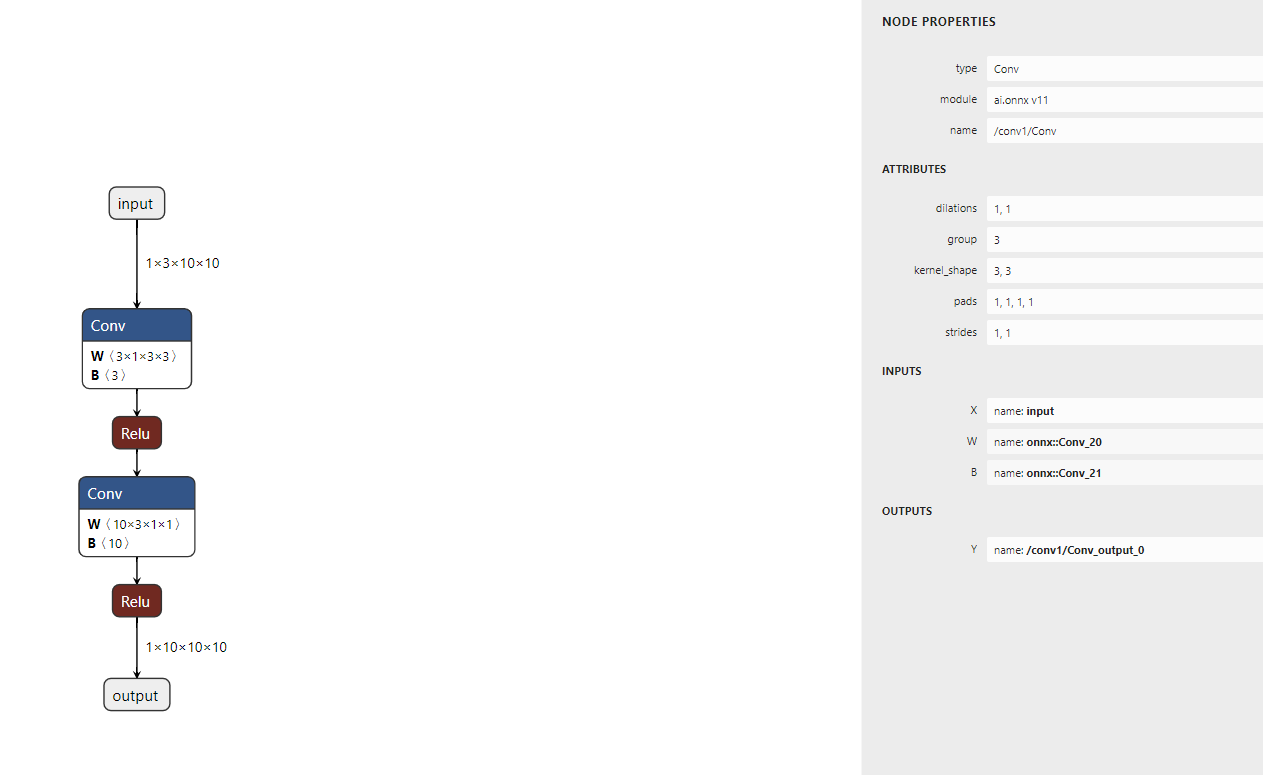

## DenseNet (2016) - DenseBlock

DenseNet靠每次Conv.都是用少channel的量進行運算，然後幾次Conv.再將所有的特徵圖串聯在一起，這時候的特徵數夠多後，再利用1*1 Conv.降維度的同時進行特徵圖融合。

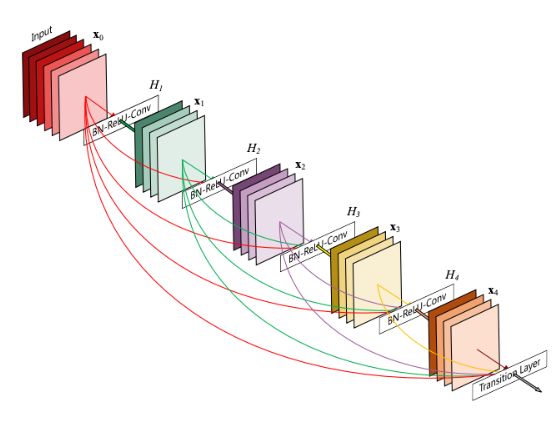

In [11]:
class DenseBlock(nn.Module):
    def __init__(self, inplanes, outplanes, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, outplanes, kernel_size=3, stride=1,
                               padding=1, bias=False)
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        return torch.cat([x, out], 1)
    
DenseB = DenseBlock(inplanes=3,outplanes=10)
print(DenseB)

# Export the model to ONNX
dummy_input = torch.rand(1,3,10,10)
torch.onnx.export(
    model=DenseB,                        # Your model instance
    args=dummy_input,                     # Model's input tensor (or a tuple for multiple inputs)
    f='./onnx/DenseBlock.onnx',              # Path to save the ONNX model
    opset_version=11,                     # ONNX opset version to use
    input_names=['input'],                # Optionally define the input tensor name
    output_names=['output'],              # Optionally define the output tensor name
)


DenseBlock(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


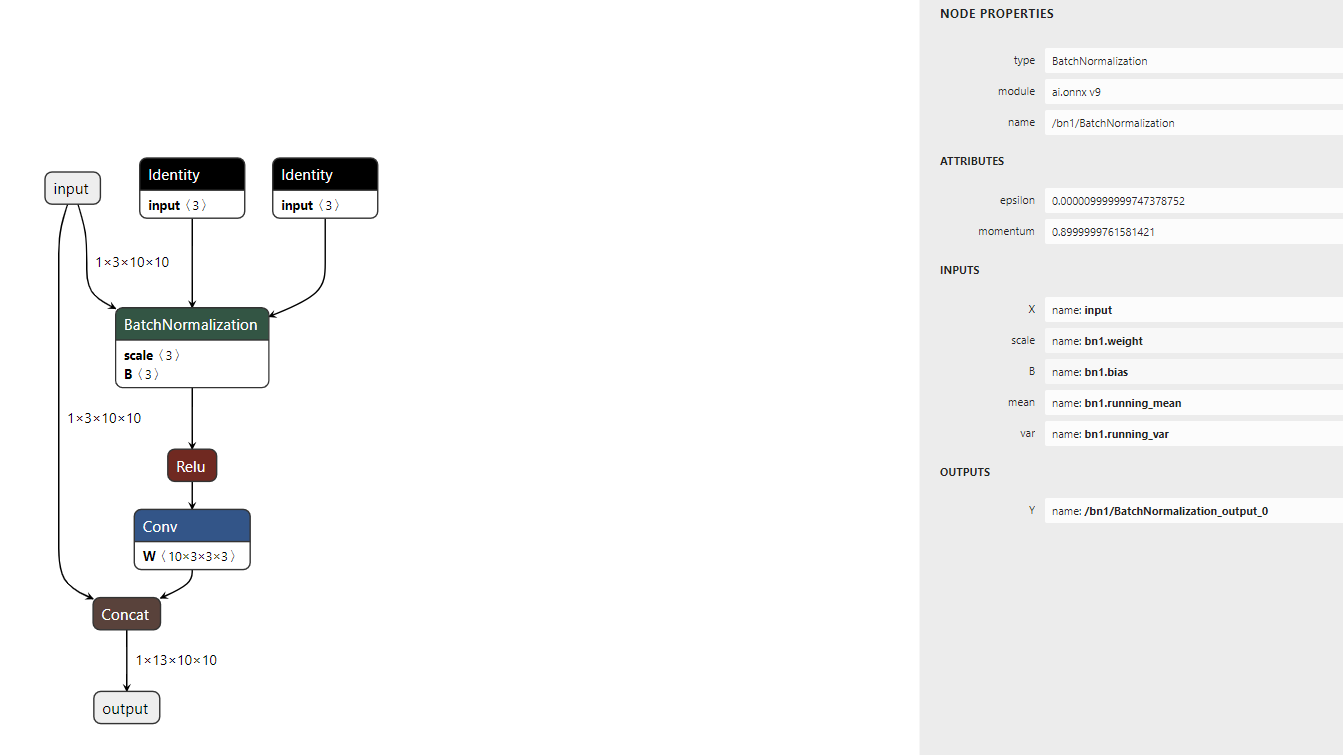

## GoogleLeNet V1 - InceptionBlock

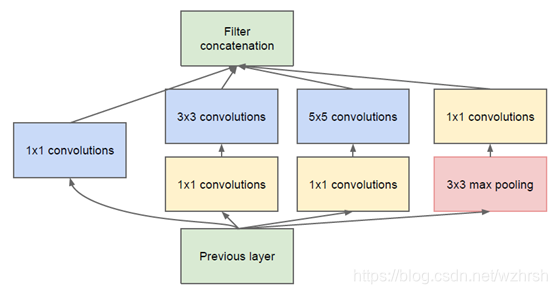

In [12]:
# Inception模块
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_chanel_1, out_channel_3_reduce, out_channel_3,
                 out_channel_5_reduce, out_channel_5, out_channel_pool):
        super(InceptionBlock, self).__init__()

        self.block1 = nn.Conv2d(in_channels=in_channels, out_channels=out_chanel_1, kernel_size=1)
        
        self.block2 = nn.Sequential(
                      nn.Conv2d(in_channels=in_channels, out_channels=out_channel_3_reduce, kernel_size=1),
                      nn.Conv2d(in_channels=out_channel_3_reduce, out_channels=out_channel_3, kernel_size=3, padding=1))

        self.block3 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channel_5_reduce, kernel_size=1),
                      nn.Conv2d(in_channels=out_channel_5_reduce, out_channels=out_channel_5, kernel_size=5, padding=2))

        self.block4 = nn.Sequential(nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
                     nn.Conv2d(in_channels=in_channels, out_channels=out_channel_pool, kernel_size=1))
        

    def forward(self, x):
        out1 = self.block1(x)
        out2 = self.block2(x)
        out3 = self.block3(x)
        out4 = self.block4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1) #batch * (out1ch + out2ch + out3ch + out4ch)  * w * h
        return out


InceptionB = InceptionBlock(in_channels=128,
                            out_chanel_1=160, 
                            out_channel_3_reduce=112, out_channel_3=224,
                            out_channel_5_reduce=24, out_channel_5=64, 
                            out_channel_pool=64)
print(InceptionB)

# Export the model to ONNX
dummy_input = torch.rand(1,128,10,10)
torch.onnx.export(
    model=InceptionB,                        # Your model instance
    args=dummy_input,                     # Model's input tensor (or a tuple for multiple inputs)
    f='./onnx/InceptionB.onnx',              # Path to save the ONNX model
    opset_version=11,                     # ONNX opset version to use
    input_names=['input'],                # Optionally define the input tensor name
    output_names=['output'],              # Optionally define the output tensor name
)

InceptionBlock(
  (block1): Conv2d(128, 160, kernel_size=(1, 1), stride=(1, 1))
  (block2): Sequential(
    (0): Conv2d(128, 112, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(112, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (block3): Sequential(
    (0): Conv2d(128, 24, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (block4): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  )
)


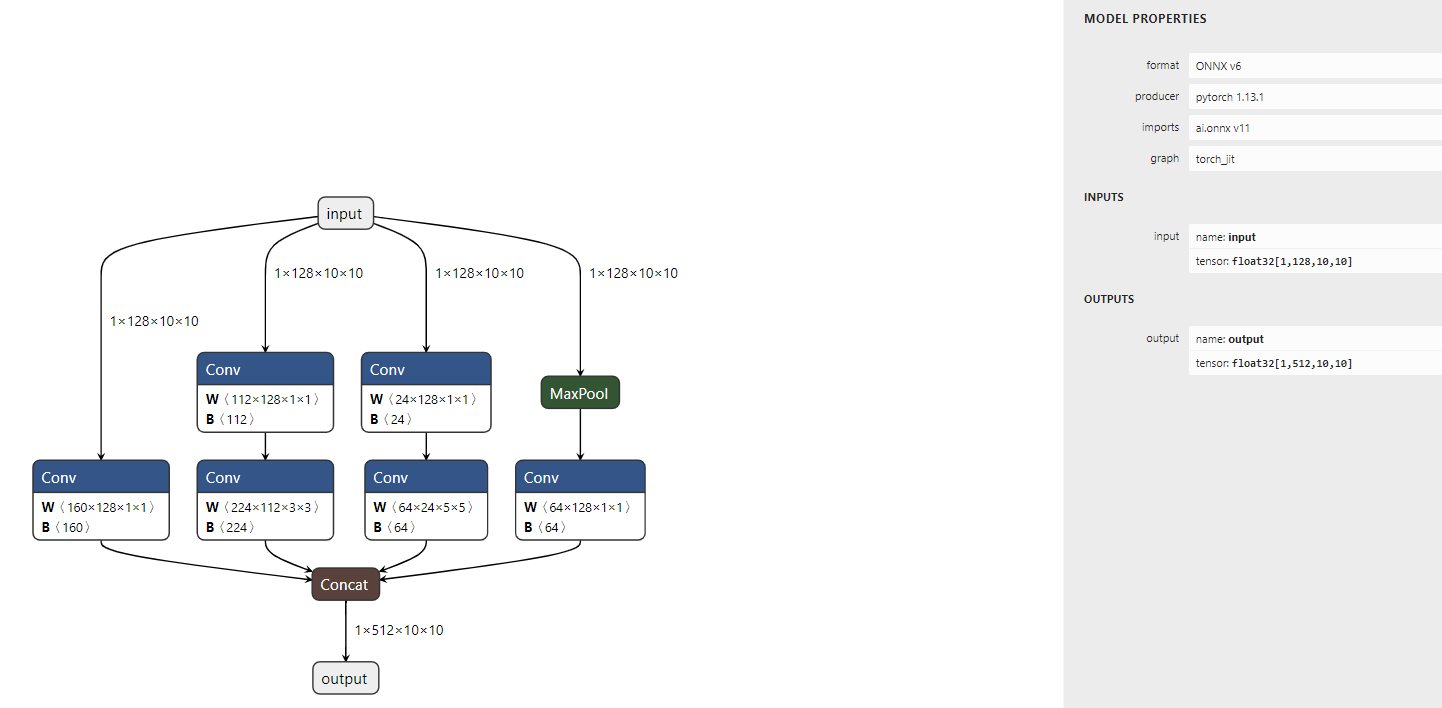